# Réseaux pleinement connectés 

Cet exercice fait suite au devoir 1.  L'objectif ici est d'implanter un réseau pleinement connecté avec une approche plus modulaire. Pour chaque couche, vous serez appelé à implanter une fonction `forward` et une fonction `backward`. La fonction `forward` reçoit en entrée un tenseur `x`, des poids `w` et possiblement d'autres parameters, et retourne le tenseur de sortie de la couche `out`.  La fonction retourne aussi une variable `cache`  contenant des données utilisés pour la rétropropagation (fonction `backward`).  La structure de la fonction `forward` est la suivante : 

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

N'oubliez pas que `x` est une `batch` et donc conbient plus d'un élément.

En rétropropagation, la fonction `backward` de la couche reçoit en entrée un tenseur de dérivées `dout` ainsi que la liste `cache` calculée lors de la propagation avant (fonction `forward`).  Elle retourne deux tenseurs de gradients: un par rapport à ses entrée (`dx`) et un par rapport à ses poids (`dw`) (et parfois un par rapport aux bias `db`).  La structure de la fonction `backward` est la suivante : 

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

Une fois ce type de couches implanté, il sera possible de les combiner ensemble et ainsi construire des réseaux de neurones de différentes architectures.

En plus des réseaux pleinement connectés, nous explorerons différents algorithme de descente de gradient et  introduirons *Dropout* et *Batch Norm*.
  

In [43]:
# As usual, a bit of setup

#import time
import numpy as np
import matplotlib.pyplot as plt
from ift725.classifiers.fc_net import *
from ift725.data_utils import get_CIFAR10_data
from ift725.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from ift725.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

print('setup done!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
setup done!


In [44]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Couche pleinement connectée : propagation avant
Dans le fichier `ift725/layers.py`, vous devez coder la fonction `forward_fully_connected` et la tester avec le code de la cellule suivante.

In [45]:
# Test the forward_fully_connected function : batch 1 and 1 output neuron

input_shape = (2, 2, 3) # an 2x2x3 input variable (a CIFAR10 image would have a 32x32x3 shape)

input_size = np.prod(input_shape) # here 12
weight_size = np.prod(input_shape) # here 12

x = np.floor(np.linspace(-0.1, 0.5, num=input_size).reshape(1, *input_shape)*10)
w = np.floor(np.linspace(-0.2, 0.3, num=weight_size).reshape(weight_size, 1)*10)
b = np.linspace(-0.3, 0.1, num=1)

print('x-shape  = ', x.shape)
print('w-shape  = ', w.shape)
print('b-shape  = ', b.shape)

out, _ = forward_fully_connected(x, w, b)
correct_out = 36.7

print('out = ', out)
print('correct_out = ', correct_out)

# Compare your output with ours. The error should be around 1e-9.
print('Testing forward_fully_connected function:')
print('difference: ', rel_error(out, correct_out))

x-shape  =  (1, 2, 2, 3)
w-shape  =  (12, 1)
b-shape  =  (1,)
out =  [[36.7]]
correct_out =  36.7
Testing forward_fully_connected function:
difference:  0.0


In [46]:
# Test the forward_fully_connected function : batch 2 and 1 output neuron

num_inputs = 2          # batch of 2 input variables
input_shape = (2, 2, 3) # an 2x2x3 input variable (a CIFAR10 image would have a 32x32x3 shape)

input_size = num_inputs * np.prod(input_shape) # here 2x12 = 24
weight_size = np.prod(input_shape) # here 12

x = np.floor(np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)*10)
w = np.floor(np.linspace(-0.2, 0.3, num=weight_size).reshape(weight_size, 1)*10)
b = np.linspace(-0.3, 0.1, num=1)

print('x-shape  = ', x.shape)
print('w-shape  = ', w.shape)
print('b-shape  = ', b.shape)

out, _ = forward_fully_connected(x, w, b)
correct_out = np.array([14.7, 20.7])

print('out = ', out)
print('correct_out = ', correct_out)

# Compare your output with ours. The error should be around 1e-9.
print('Testing forward_fully_connected function:')
print('difference: ', rel_error(out.T, correct_out))

x-shape  =  (2, 2, 2, 3)
w-shape  =  (12, 1)
b-shape  =  (1,)
out =  [[14.7]
 [20.7]]
correct_out =  [14.7 20.7]
Testing forward_fully_connected function:
difference:  0.0


In [47]:
# Test the forward_fully_connected function : batch 2 and 2 output neurons
num_inputs = 2          # batch of 2 input variables
input_shape = (2, 2, 3) # each variable as a 2x2x3 shape (a CIFAR10 RBG image would have a 32x32x3 shape)
output_dim = 2          # the output has 2 neurons

input_size = num_inputs * np.prod(input_shape)  #here 2x2x2x3 = 24
weight_size = output_dim * np.prod(input_shape) #here 2x12 = 24

x = np.floor(np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)*10)
w = np.floor(np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)*10)
b = np.linspace(-0.3, 0.1, num=output_dim)

print('x-shape  = ', x.shape)
print('w-shape  = ', w.shape)
print('b-shape  = ', b.shape)

out, _ = forward_fully_connected(x, w, b)
correct_out = np.array([[ 12.7,  14.1],
                        [ 11.7,  23.1]])

print('out = ', out)
print('correct_out = ', correct_out)

# Compare your output with ours. The error should be around 1e-9.
print('Testing forward_fully_connected function:')
print('difference: ', rel_error(out, correct_out))

x-shape  =  (2, 2, 2, 3)
w-shape  =  (12, 2)
b-shape  =  (2,)
out =  [[12.7 14.1]
 [11.7 23.1]]
correct_out =  [[12.7 14.1]
 [11.7 23.1]]
Testing forward_fully_connected function:
difference:  0.0


# Couche pleinement connectée : rétro-propagation
If faut maintenant implanter la fonction `backward_fully_connected` et tester votre code avec un gradient numérique.

In [48]:
# Test the backward_fully_connected function
# Here a case for a batch of 10 elements
# Each elements has a 2x3 size
# The layer has 5 output neurons

x = np.random.randn(10, 2, 3)  # batch of 10 elements, each of size 2x3
w = np.random.randn(6, 5)      # 2x3=6 weigts times 5 output neurones
b = np.random.randn(5)         # one bias for each output neurone
dout = np.random.randn(10, 5)  # the upcoming gradient at each output neuron and for each element of the batch

dx_num = eval_numerical_gradient_array(lambda x: forward_fully_connected(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: forward_fully_connected(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: forward_fully_connected(x, w, b)[0], b, dout)

_, cache = forward_fully_connected(x, w, b)
dx, dw, db = backward_fully_connected(dout, cache)

# The error should be around 1e-10
print('Testing backward_fully_connected function:')
print('dx error: ', rel_error(dx_num, dx))  #Gradient with respect to the input x : size 10x2x3
print('dw error: ', rel_error(dw_num, dw))  #Gradient with respect to the weights w : size 5x6
print('db error: ', rel_error(db_num, db))  #Gradient with respect to the bias : size 5

Testing backward_fully_connected function:
dx error:  1.1246387657109133e-10
dw error:  7.727938870443399e-11
db error:  9.998347376917905e-12


# Couche ReLU : propagation avant
Il faut implanter la fonction d'activation ReLU avec la fonction `relu_forward`.  Testez votre implantation avec la cellule que voici:

In [49]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = forward_relu(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print('Testing forward_relu function:')
print('difference: ', rel_error(out, correct_out))

Testing forward_relu function:
difference:  4.999999798022158e-08


# Couche ReLU : rétropropagation
Maintenant il faut implanter la rétro-propagation pour une fonction d'activation ReLU via la fonction `relu_backward`.  Testez votre implantation avec le gradient numérique que voici:

In [50]:
x = np.random.randn(2, 2)
dout = np.random.randn(*x.shape) # Upstream gradient that retropropagates at that layer
print("x = ", x)
print("dout  = ", dout)

dx_num = eval_numerical_gradient_array(lambda xx: forward_relu(xx)[0], x, dout)

_, cache = forward_relu(x)
dx = backward_relu(dout, cache)

# The error should be around 1e-12
print('Testing backward_relu function:')
print('dx error: ', rel_error(dx_num, dx))

x =  [[-0.68371282 -1.01872629]
 [ 0.48759992 -1.92437926]]
dout  =  [[ 0.76511548  1.12817705]
 [ 1.37041642 -0.26215004]]
Testing backward_relu function:
dx error:  5.000156469950984e-13


# Couches "Combo"
Souvent, on combine une couche pleinement connectée avec une fonction d'activation comme ReLU. Afin de simplifier ces situations, nous avons différentes fonctions à cet effet dans `ift725/layer_combo.py`.

Pour l'instant, nous porterons notre attention sur les fonctions `forward_fully_connected_transform_relu` et `backward_fully_connected_transform_relu`.  Vous pouvez vérifier le code à l'aide de la vérification numérique que voici:

In [51]:
from ift725.layer_combo import forward_fully_connected_transform_relu, backward_fully_connected_transform_relu

x = np.random.randn(2, 3, 4)  # Batch of 2 elements of size 3x4
w = np.random.randn(12, 10)   # 10 output neurons, each associated with 12=3x4 weights
b = np.random.randn(10)       # 10 biases
dout = np.random.randn(2, 10) # up stream gradient for each neuron (10) and each batch element (2)

out, cache = forward_fully_connected_transform_relu(x, w, b)
dx, dw, db = backward_fully_connected_transform_relu(dout, cache)

dx_num = eval_numerical_gradient_array(lambda xx: forward_fully_connected_transform_relu(xx, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda ww: forward_fully_connected_transform_relu(x, ww, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda bb: forward_fully_connected_transform_relu(x, w, bb)[0], b, dout)

# Error should be around 1e-10
print('Testing forward_fully_connected_transform_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing forward_fully_connected_transform_relu:
dx error:  3.833607796511522e-11
dw error:  1.1918668994647957e-10
db error:  7.826678804272781e-12


# Fonctions de perte : Softmax et SVM
Au devoir 1, vous avez implanter ces deux fonctions de perte.  Vous devez donc récupérer votre code et l'adapter aux fonctions `softmax_loss` et `svm_loss` du fichier `ift725/layers.py`.

Afin de vous assurer que tout fonctionne pour le mieux, exécutez le code que voici:

In [52]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=True)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999730693760556
dx error:  1.4021566006651672e-09
(0, 0) 0.001999119936257898
(0, 1) 0.0020029801151011384
(0, 2) 0.001998267196157144
(0, 3) 0.002000561249992927
(0, 4) 0.0020000855416313357
(0, 5) -0.017998485746240078
(0, 6) 0.002000098175969356
(0, 7) 0.0019980078924675126
(0, 8) 0.002000843024596577
(0, 9) 0.001998522547452808
(1, 0) 0.0019967709707913173
(1, 1) 0.0019994660593880553
(1, 2) -0.01799717426198555
(1, 3) 0.001999686505271825
(1, 4) 0.002003623422730527
(1, 5) 0.002000420762371391
(1, 6) 0.002000074594832313
(1, 7) 0.002000061027906952
(1, 8) 0.001998359078214662
(1, 9) 0.0019987118404785065
(2, 0) 0.001996816667571011
(2, 1) 0.0020022469460201364
(2, 2) 0.001999266130425781
(2, 3) 0.002001608434554214
(2, 4) 0.0019988665389547577
(2, 5) 0.001998489951304805
(2, 6) 0.002001678534035989
(2, 7) 0.0020028409819516924
(2, 8) -0.01800300430954138
(2, 9) 0.0020011901691319167
(3, 0) 0.0020003121381506617
(3, 1) 0.0019981145626957186
(3, 2) 0.00200

# Réseau à deux couches
Au tp1, vous avez implanté un réseau à deux couches à l'intérieur d'une seule classe monolitique. Maintenant que les couches ont un design plus modulaire, vous devez implanter un réseau à deux couches de façon modulaire.

Avec le fichier `ift725/classifiers/fc_net.py`, vous devez compléter l'implantation de la classe `TwoLayerNeuralNet`. Le design de cette classe est le prototype pour les autres réseaux utilisés dans ce devoir.  Par conséquent, soyez attentifs et assurez-vous de bien comprendre cet API. Vous pouvez exécuter la cellule que voici pour tester votre code.

In [53]:
# First, lets try a forward pass for a minibatch of 3 elements of size 5, with an hidden layer of size 50 and 7 classes

N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNeuralNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'


print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)

correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'
print('score difference = ', scores_diff)


Testing initialization ... 
Testing test-time forward pass ... 
score difference =  5.115852452775016e-08


In [54]:
# Now lets compute the loss with and without regularization
y = np.asarray([0, 5, 1])

model.reg = 0.0  # NO REG
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'
print('loss difference = ', abs(loss - correct_loss))

model.reg = 1.0  # WITH REG
loss, grads = model.loss(X, y)
# correct_loss = 63.9539735065
correct_loss = 26.5948426952 ########################## TODO: check avec le prof!!
print('loss = ', loss, '  correct_loss = ', correct_loss)
print('loss difference = ', abs(loss - correct_loss))
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'


loss difference = 4.61053417666335e-12
loss =  26.594842695238583   correct_loss =  26.5948426952
loss difference =  3.858247055177344e-11


In [55]:
# Now lets compute the loss with different regularization terms

for reg in [0.0, 0.3, 0.6, 0.9]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.31e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.3
W1 relative error: 3.80e-08
W2 relative error: 6.17e-10
b1 relative error: 1.00e+00
b2 relative error: 1.00e+00
Running numeric gradient check with reg =  0.6
W1 relative error: 4.14e-08
W2 relative error: 2.43e-09
b1 relative error: 1.00e+00
b2 relative error: 1.00e+00
Running numeric gradient check with reg =  0.9
W1 relative error: 1.70e-08
W2 relative error: 1.31e-08
b1 relative error: 1.00e+00
b2 relative error: 1.00e+00


# Solver
Au tp1, l'entraînement des modèles était couplé aux modèles. Suivant un design plus modulaire, dans ce tp nous avons séparé le code d'entraînement et le code des modèles dans différentes classes.

Familiarisez-vous avec le code `ift725/solver.py` et assurez-vous de bien en comprendre le fonctionnement. Après, utilisez un `Solver` pour entraîner le `TwoLayerNeuralNet` et atteindre environ `50%` de justesse en validation sur le base de donnée CIFAR10 stockée dans la variable `data`.

In [56]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


In [57]:

##############################################################################
# TODO: Utilisez une instance de Solver pour entrainer un TwoLayerNeuralNet  #
#  qui atteint au moins 50% de précision sur l'ensemble de validation.       #
##############################################################################
model = TwoLayerNeuralNet(reg=1)
solver = Solver(model, data,
                  update_rule='sgd',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  lr_decay=0.90,
                  num_epochs=10, batch_size=200,
                  print_every=100)
solver.train()

##############################################################################
#                             FIN DE VOTRE CODE                              #
##############################################################################

(Iteration 1 / 2450) loss: 2.455785
(Epoch 0 / 10) train acc: 0.114000; val_acc: 0.106000
(Iteration 101 / 2450) loss: 2.052526
(Iteration 201 / 2450) loss: 1.741127
(Epoch 1 / 10) train acc: 0.437000; val_acc: 0.424000
(Iteration 301 / 2450) loss: 1.752448
(Iteration 401 / 2450) loss: 1.668664
(Epoch 2 / 10) train acc: 0.481000; val_acc: 0.473000
(Iteration 501 / 2450) loss: 1.655763
(Iteration 601 / 2450) loss: 1.677563
(Iteration 701 / 2450) loss: 1.626176
(Epoch 3 / 10) train acc: 0.480000; val_acc: 0.474000
(Iteration 801 / 2450) loss: 1.501876
(Iteration 901 / 2450) loss: 1.540429
(Epoch 4 / 10) train acc: 0.506000; val_acc: 0.481000
(Iteration 1001 / 2450) loss: 1.554444
(Iteration 1101 / 2450) loss: 1.511626
(Iteration 1201 / 2450) loss: 1.496665
(Epoch 5 / 10) train acc: 0.526000; val_acc: 0.482000
(Iteration 1301 / 2450) loss: 1.532127
(Iteration 1401 / 2450) loss: 1.653367
(Epoch 6 / 10) train acc: 0.544000; val_acc: 0.505000
(Iteration 1501 / 2450) loss: 1.414839
(Iteration

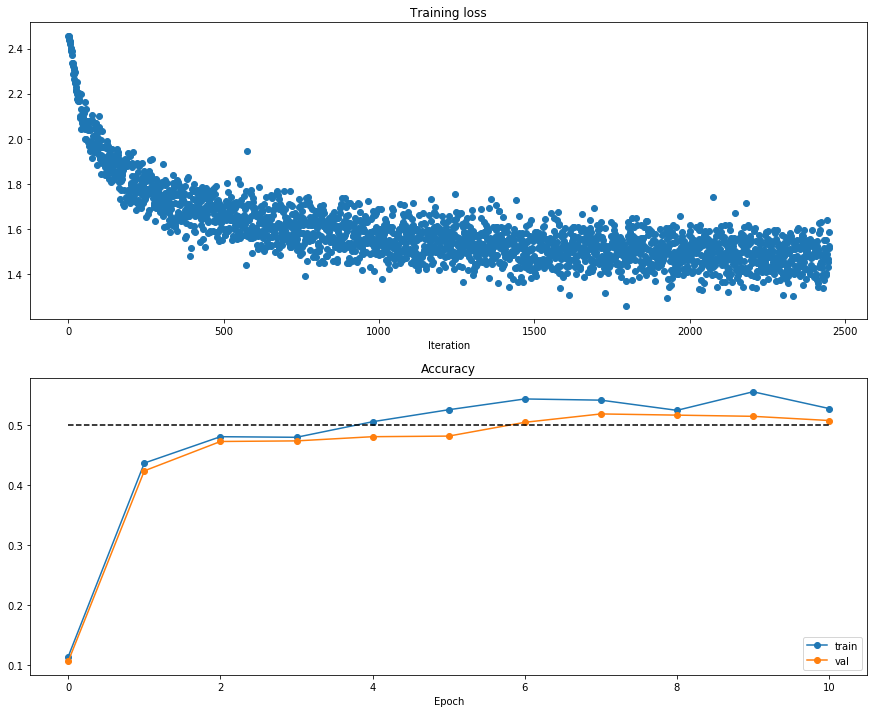

In [58]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Réseau de neurones multi-couches
Maintenant vous devez implanter un réseau ayant un nombre arbitraire de couches.

Pour ce faire, prenez connaissance de la classe `FullyConnectedNeuralNet` du fichier `ift725/classifiers/fc_net.py`.

Vous devez implanter **l'initialization, la propagation avant et la rétro-propagation**. Pour le moment, ne vous souciez pas de dropout ni de batch norm.

##  Fonction de perte et vérification du gradient

La prochaine cellule effectue une vérification dilligente.  Exécutez la cellule afin de vous assurez que la loss avec et sans régularisation fonctionne. 

In [59]:
from ift725.classifiers.fc_net import *
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,)) 

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNeuralNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
    
  # Relative error should be below 1e-5
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.306230441455729
W1 relative error: 1.73e-07
W2 relative error: 1.43e-07
W3 relative error: 2.45e-07
b1 relative error: 2.10e-08
b2 relative error: 1.11e-08
b3 relative error: 1.32e-10
Running check with reg =  3.14
Initial loss:  7.275938074081683
W1 relative error: 7.93e-09
W2 relative error: 2.63e-08
W3 relative error: 6.13e-08
b1 relative error: 2.14e-08
b2 relative error: 3.60e-08
b3 relative error: 1.38e-10


## Question 1:

Pourquoi croyez-vous que les résultats de la cellule précédentes font foi d'une bonne fonction de perte?
     
**Votre réponse:** ...

Autre vérification diligente, assurez-vous que votre code peut "overfitter" sur un petit ensemble de 50 images. Pour ce faire, essayons un réseau à 3 couches cachées ayant chacune 100 neurones. Une recherche d'hyper-paramètres sera effectué pour trouver le bon taux d'apprentissage (learning rate) ainsi que le `weight_scale`.  Vous devriez être capable d'atteindre une justesse en entraînement de 100% avec 20 epochs.

In [93]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

best_weight_scale = 0.
best_learning_rate = 0.
best_training_acc = 0.

##############################################################################
# TODO: Utilisez une instance de Solver pour entrainer un réseau à 3 couches #
#  et 100 neurones par couche à overfitter 50 images de CIFAR10.  Il est     #
#  suggéré d'effectuer une recherche d'hyperparamètres pour trouver le bon   #
#  `learning_rate` et le bon `weight_scale`.                                 #
##############################################################################

results = {}
D, C = 3*32*32, 10

for _ in range(40):
  w_sc = 10 ** uniform(-2, -1)
  lr = 10 ** uniform(-4, -2)
  model = FullyConnectedNeuralNet([100, 100, 100], input_dim=D, num_classes=C,
                              reg=reg, weight_scale=w_sc, dtype=np.float64)

  solver = Solver(model, small_data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': lr,
                    },
                    lr_decay=0.90,
                    num_epochs=20, batch_size=200,
                    verbose=False,
                    print_every=10)
  solver.train()
  training_acc = solver.train_acc_history[-1]
  results[(w_sc, lr)] = training_acc
  if best_training_acc < training_acc:
    best_training_acc = training_acc
    best_weight_scale = w_sc
    best_learning_rate = lr
  print()


##############################################################################
#                             FIN DE VOTRE CODE                              #
##############################################################################

print('The best learning_rate, weight_scale and training accuracy are',best_weight_scale, best_learning_rate, best_training_acc)

dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4'])


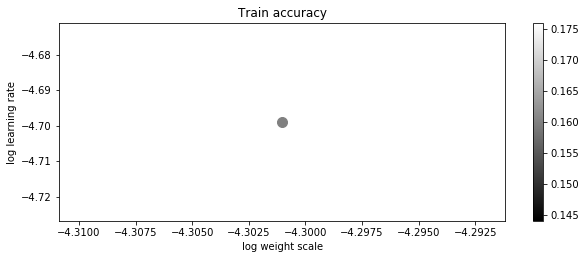

In [91]:
# Visualize the cross-validation results
# import math

print(solver.best_params.keys())

marker_size = 100
x_scatter, x_label = [np.log10(x[0]) for x in results], 'log weight scale'
y_scatter, y_label = [np.log10(x[1]) for x in results], 'log learning rate'

# plot validation accuracy
colors = [results[x] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Train accuracy')
plt.show()

Maintenant, faites la même chose pour un réseau à 5 couches.

0.08244892757367263 0.0001447214465218693 

final loss: 0.09753202965749994  train_acc: 0.98


0.03950534299390841 0.0007040187359181699 

final loss: 1.7608839949287471  train_acc: 0.58


0.06689760755551451 0.00014992117249948056 

final loss: 0.6986031981513514  train_acc: 0.78


0.028285199985315507 0.0007027475833965151 

final loss: 2.26033093973327  train_acc: 0.16


0.058067474742138706 0.005540180440401501 

final loss: 0.06415006793903266  train_acc: 1.0


0.022586355621508066 0.000565298862675916 

final loss: 2.289538150474039  train_acc: 0.28


0.06150347370921556 0.00023032592706157955 

final loss: 1.0632995871357527  train_acc: 0.76


0.01044394642584669 0.0002024734085582037 

final loss: 2.3025007355940073  train_acc: 0.16


0.08875467136483929 0.0034549748577524762 

final loss: 0.0024494291244520493  train_acc: 1.0


0.02343336618540742 0.00015217578531736412 

final loss: 2.30930403705488  train_acc: 0.16


0.02809699056436645 0.007105953301128673 

final loss: 1.4

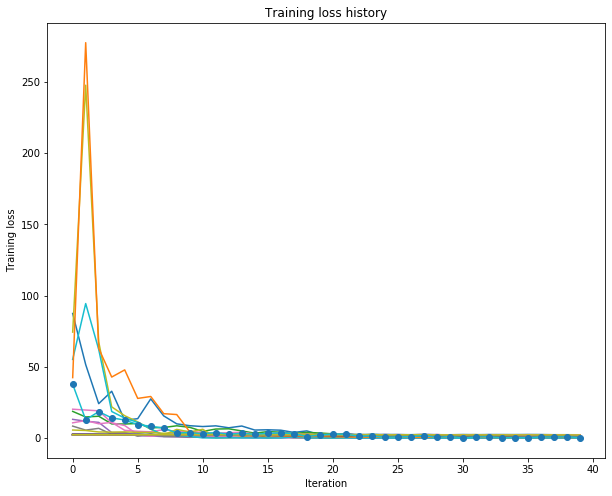

The best learning_rate, weight_scale and training accuracy are 0.0 0.0 0.0


In [80]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

##############################################################################
# TODO: Utilisez une instance de Solver pour entrainer un réseau à 5 couches #
#  à 100 neurones à overfitter 50 images de CIFAR10.  Il est suggérer de     #
#  d'effectuer une recherche d'hyperparamètres pour trouver le bon           #
#  `learning_rate` et le bon `weight_scale`.                                 #
##############################################################################

def uniform(minv, maxv):
    return np.random.rand() * (maxv - minv) + minv

results = {}
for _ in range(40):
    weight_scale = 10 ** uniform(-2, -1)
    learning_rate = 10 ** uniform(-4, -2)
    print(weight_scale, learning_rate, '\n')
    
    model = FullyConnectedNeuralNet([100, 100, 100, 100],
                  weight_scale=weight_scale, dtype=np.float64)
    solver = Solver(model, small_data,
                    print_every=10, num_epochs=20, batch_size=25,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': learning_rate,
                    }, verbose=False)
    solver.train()
    train_acc = solver.train_acc_history[-1]
    print('final loss:', solver.loss_history[-1], ' train_acc:', train_acc)
    print('\n')
    plt.plot(solver.loss_history)
    results[(weight_scale, learning_rate)] = train_acc

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()


##############################################################################
#                             FIN DE VOTRE CODE                              #
##############################################################################
best_weight_scale = 0.
best_learning_rate = 0.
best_training_acc = 0.
print('The best learning_rate, weight_scale and training accuracy are',best_weight_scale, best_learning_rate, best_training_acc)

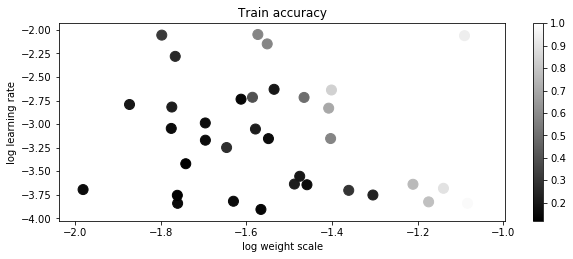

In [82]:
# Visualize the cross-validation results
# import math
marker_size = 100
x_scatter, x_label = [np.log10(x[0]) for x in results], 'log weight scale'
y_scatter, y_label = [np.log10(x[1]) for x in results], 'log learning rate'

# plot validation accuracy
colors = [results[x] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Train accuracy')
plt.show()

# Descente de gradient ++
Jusqu'à présent nous avons utilisé l'algorithmes de base de la descente de gradient (SGD-stochastic gradient descent). Ici nous testerons d'autres algorithmes plus sophistiqués.

# SGD+Momentum
SGD+momentum est très largement utilisé.  Ouvrez  `ift725/optim.py` et prenez connaissance du code et implémentez la fonction `sgd_momentum` et exécutez la cellule que voici. Votre erreur devrait être inféreieure à 1e-6.

In [ ]:
from ift725.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
    [-0.39994,    -0.34737526, -0.29481053, -0.24224579, -0.18968105],
    [-0.13711632, -0.08455158, -0.03198684,  0.02057789,  0.07314263],
    [ 0.12570737,  0.17827211,  0.23083684,  0.28340158,  0.33596632],
    [ 0.38853105,  0.44109579,  0.49366053,  0.54622526,  0.59879   ]])
expected_velocity = np.asarray([
    [-0.06 ,       0.00684211,  0.07368421,  0.14052632,  0.20736842],
    [ 0.27421053,  0.34105263,  0.40789474,  0.47473684,  0.54157895],
    [ 0.60842105,  0.67526316,  0.74210526,  0.80894737,  0.87578947],
    [ 0.94263158,  1.00947368,  1.07631579,  1.14315789,  1.21      ]])

# Error should be below 1e-06
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

Maintenant, excécutez cette cellule.  Normalement, le réseau à 6 couches devrait s'entraîner plus rapidement avec SGD+momentum qu'avec SGD.

In [ ]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNeuralNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=10, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, '-o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp et Adam
RMSProp [1] et Adam [2] sont d'autres algorithmes de descente de gradient dont le code est dans le fichier `ift725/optim.py`.   Alors que le code de Adam vous est fournit, vous devez rédigé celui de RMSProp.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [ ]:
# Test RMSProp implementation; you should see errors less than 1e-7
import numpy as np
from ift725.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
    [-0.39,       -0.33846964, -0.2868865,  -0.23525427, -0.18357633],
    [-0.13185574, -0.0800953,  -0.02829757,  0.02353511,  0.07540058],
    [ 0.12729687,  0.17922215,  0.23117507,  0.28315533,  0.33516143],
    [ 0.38719188,  0.43924528,  0.49132033,  0.54341585,  0.59553073]])
expected_cache = np.asarray([
    [0.6,        0.61510526, 0.63021053, 0.64531579, 0.66042105],
 [0.67552632, 0.69063158, 0.70573684, 0.72084211, 0.73594737],
 [0.75105263, 0.76615789, 0.78189474, 0.79805263, 0.81421053],
 [0.83036842, 0.84652632, 0.86268421, 0.87884211, 0.895     ]])  


print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

In [ ]:
# Test Adam implementation; you should see errors around 1e-7 or less
from ift725.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, config = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

Exécuter le code que voici afin de comparer ces différent algorithmes.  En pricipe Adam devrait être le meilleur algorithme.

In [ ]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNeuralNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=10, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Entraînez un bon model!
Entraînez le meilleur réseau de neurones possible sur CIFAR-10 et mettez le meilleur modèle dans la variable `best_model`. Vous devriez avoir au moins une justesse 50% (voire même 55%) en validation et en test.

Plus tard dans le devoir, on vous demandera d'entrainer et de tester une réseau convolutionnel sur CIFAR-10.  Vous verrez alors que cette architecture est supérieure aux réseaus de neurones pleinement connectés.

NOTE: il serait judicieux de compléter le notebook `BatchNormalization.ipynb` et `Dropout.ipynb` avant de compléter cette dernière partie.

In [ ]:
do_delete = True

In [ ]:
if do_delete:
    trys = []
    best_try = -1
    best_val_acc = 0
    print('Deleted trys')
else:
    print('Did not delete trys')
do_delete = False

In [ ]:
best_model = None
################################################################################
# TODO: Entrainez le meilleur FullyConnectedNeuralNet que vous pouvez sur les  #
#  données CIFAR-10. Vous pourriez trouver la normalization par lots et le     #
#  dropout utile. Stockez votre meilleur modèle dans la variable best_model.   #
################################################################################

def uniform(minv, maxv):
    return np.random.rand() * (maxv - minv) + minv

if 'trys' not in locals():
    trys = []
    best_try = -1
    best_val_acc = 0
for i in range(1):
    # reg 0.00779190546432  lr 0.000423844376859
    # reg 0.000204588367827 lr 0.000529341067109
    weight_scale = 3e-2  # 10 ** uniform(-3, -1)
    lr = 10 ** -2.5  # 10 ** uniform(-4, -2)
    reg = 1e-10  # 10 ** uniform(-6, -3)
    
    model = FullyConnectedNeuralNet([100] * 5, weight_scale=weight_scale, reg=reg, use_batchnorm=True)

    solver = Solver(model, data,
                  num_epochs=30, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': lr
                  },
                  print_every=200,
                  verbose=True)
    solver.train()
    
    max_val_acc = np.max(solver.val_acc_history)
    cur_index = len(trys)
    print('Try', cur_index, 'Max accu. val.', max_val_acc, 'p:', weight_scale, reg, lr, ('Record!' if max_val_acc > best_val_acc else ''))
    trys.append({
            'ws': weight_scale, 'reg': reg, 'lr': lr,
            'maxvacc': max_val_acc,
            'lossh': solver.loss_history,
            'tacch': solver.train_acc_history,
            'vacch': solver.val_acc_history,
            'model': model
        })
    
    if max_val_acc > best_val_acc:
        best_val_acc = max_val_acc
        best_try = cur_index
        
print('Best try:', best_try)
print('Total tries', len(trys))
################################################################################
#                              FIN DE VOTRE CODE                               #
################################################################################

In [ ]:
# Visualize the cross-validation results
forget = 0
new_tries = trys[forget:]
marker_size = 100
#x_scatter, x_label = [np.log10(x['ws']) for x in new_tries], 'log weight scale'
x_scatter, x_label = [np.log10(x['lr']) for x in new_tries], 'log lr'
y_scatter, y_label = [np.log10(x['reg']) for x in new_tries], 'log reg'

# plot validation accuracy
colors = [x['maxvacc'] for x in new_tries] # default size of markers is 20
isorted = np.argsort(colors)
x_scatter = np.asarray(x_scatter)[isorted]
y_scatter = np.asarray(y_scatter)[isorted]
colors = np.asarray(colors)[isorted]
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Validation accuracy')
plt.show()

In [ ]:
ref = trys[best_try]
best_try = -1
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.plot(trys[best_try]['lossh'], '-')
plt.plot(ref['lossh'], '-')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.plot(trys[best_try]['tacch'], '-', label='Train')
plt.plot(trys[best_try]['vacch'], '-', label='Valid')
plt.plot(ref['tacch'], '-', label='Train ref')
plt.plot(ref['vacch'], '-', label='Valid ref')
plt.legend(loc='lower center')

plt.tight_layout(pad=0, w_pad=0, h_pad=2)
plt.show()

# Test your model
Run your best model on the validation and test sets. You should achieve above 53% accuracy on the validation set.

In [ ]:
best_model = trys[best_try]['model']
X_test = data['X_test']
y_test = data['y_test']
X_val  = data['X_val']
y_val  = data['y_val']
y_test_pred = np.argmax(best_model.loss(X_test), axis=1)
y_val_pred = np.argmax(best_model.loss(X_val), axis=1)
print('Validation set accuracy: ', (y_val_pred == y_val).mean())
print('Test set accuracy: ', (y_test_pred == y_test).mean())